# Trabalho 05 - Planejamento de Sistema Elétricos

Aluno: Caio Cesar Amorim Silva

Matrícula: 120100002

Objetivos: Realizar o ajuste do Modelo Auto-Regressivo

LINKS IMPORTANTES:

- SLIDES: https://docs.google.com/presentation/d/1ILQHT9gibRUmB12vT5fFJz2SaCMboRCEIx4rTxa5Ngc/edit?usp=sharing


In [1]:
# Instalando as bibliotecas necessárias
!pip install PySDDP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.7/191.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=a56f1a14d0c77585d83e5fce86da1309bbb2415e01512df983c8e2cb0705ad4b
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26307 sha256=e1a30e98646ff0f4a6271386b50702219da1c9b51fbf5b32ccc7f98edae99a42
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built pyswarm typing


## Leitura de Dados do Newave

Os dados do Newave estão no drive do autor e corresponde ao mês de Agosto de 2023 (08/2023).

In [2]:
from google.colab import drive, files
import os

#Montar o Google Drive no Colab com o nome gdrive

drive.mount('/content/gdrive')

# O comando abaixo mostra qual diretório você está trabalhando momento.
print( os.getcwd() )

Caminho_do_Arquivo = 'gdrive/My Drive/NewaveAgosto2023/'
# O comando mostra o que está presente dentro da minha pasta GIF no meu drive, que está dentro do meu drive e em Doutorado. Mudar para o diretório que vocês criaram.
print( os.listdir(Caminho_do_Arquivo) )

Mounted at /content/gdrive
/content
['ADTERM.DAT', 'DGER.DAT', 'C_ADIC.DAT', 'AGRINT.DAT', 'CURVA.DAT', 'EXPH.DAT', 'EXPT.DAT', 'REE.DAT', 'PENALID.DAT', 'GHMIN.DAT', 'LOSS.DAT', 'ARQUIVOS.DAT', 'DSVAGUA.DAT', 'CONFT.DAT', 'CDEFVAR.DAT', 'CVAR.DAT', 'ITAIPU.DAT', 'ELNINO.DAT', 'tecno.dat', 'POSTOS.DAT', 'ENSOAUX.DAT', 'HIDR.DAT', 'MENSAG.TMP', 'RE.DAT', 'GTMINPAT.DAT', 'CONFHD.DAT', 'BID.DAT', 'MODIF.DAT', 'MANUTT.DAT', 'CASO.DAT', 'VAZOES.DAT', 'VAZPAST.DAT', 'SHIST.DAT', 'NewaveMsgPortug.txt', 'TERM.DAT', 'CLAST.DAT', 'selcor.dat', 'FORMAT.TMP', 'GTMIN_CCEE_082023.xlsx', 'PATAMAR.DAT', 'SISTEMA.DAT']


In [3]:
from PySDDP.Pen import Newave

PMOAGO2023 = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


## Escolha da Usina Hidrelétrica

In [4]:
# Importando as bibliotecas necessárias
import pandas as pd

# Lendo o arquivos com os nomes das usinas
data = pd.read_csv('gdrive/My Drive/NewaveAgosto2023/CONFHD.DAT', sep='\t')

# Criando um dataframe com os dados lidos
df_confhd = pd.DataFrame(data)

# Mostando o dataframe CONFHD na tela
# print(df_confhd)

# Manipulando o dataframe
df_confhd = df_confhd.iloc[1:]               # Eliminado a linha sem dados XXXXX
df_confhd = df_confhd.reset_index(drop=True) # Resetando os indices de um dataframe


chaves_df = ['NUM',  'NOME',  'POSTO',  'JUS',  'REE',  'V.INIC',  'U.EXIS',  'MODIF',  'INIC.HIST',  'FIM HIST'] # Definindo as chaves do dataframe

#df_confhd = df_confhd.drop(chaves_df, axis=1)

# Mostrando todas as UHEs do sistema
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

print(df_confhd)

     NUM  NOME         POSTO JUS   REE V.INIC U.EXIS MODIF INIC.HIST FIM HIST
0        4 FUNIL-GRANDE  211     6   10   0.00   EX...                       
1       20 BATALHA        22    21   10  73.44   EX...                       
2       21 SERRA FACAO   251    24   10  38.84   EX...                       
3       27 CAPIM BRANC1  207    28   10  48.64   EX...                       
4       28 CAPIM BRANC2   28    31   10   0.00   EX...                       
5       29 CORUMBA IV    205   203   10  98.44   EX...                       
6       48 PIRAJU         48    49   12   0.00   EX...                       
7       66 ITAIPU         66     0    5   0.00   EX...                       
8      131 NILO PECANHA  131   133    1   0.00   EX...                       
9      132 FONTES        303   133    1   0.00   EX...                       
10     141 BAGUARI       141   143    1   0.00   EX...                       
11     153 SAO DOMINGOS  154    46   10   0.00   EX...          

In [5]:
Usina = PMOAGO2023.confhd.get('Furnas')
mes = 'Dez'   # Insira o nome dos meses no seguinte formato: Jan, Fev, Mar, Abr, Mai, Jun, Jul, Ago, Set, Out, Nov, Dez
ordem = 3

In [6]:
# Codigicação dos meses:
cod = {'Jan': 1,
       'Fev': 2,
       'Mar': 3,
       'Abr': 4,
       'Mai': 5,
       'Jun': 6,
       'Jul': 7,
       'Ago': 8,
       'Set': 9,
       'Out': 10,
       'Nov': 11,
       'Dez': 12}

In [7]:
print(Usina.keys())

dict_keys(['codigo', 'nome', 'posto', 'ree', 'vol_ini', 'status', 'modif', 'ano_i', 'ano_f', 'bdh', 'sist', 'empr', 'jusante', 'desvio', 'vol_min', 'vol_max', 'vol_vert', 'vol_min_desv', 'cota_min', 'cota_max', 'pol_cota_vol', 'pol_cota_area', 'coef_evap', 'num_conj_maq', 'maq_por_conj', 'pef_por_conj', 'cf_hbqt', 'cf_hbqt_2', 'cf_hbqt_3', 'cf_hbqt_4', 'cf_hbqt_5', 'cf_hbqg', 'cf_hbqg_2', 'cf_hbqg_3', 'cf_hbqg_4', 'cf_hbqg_5', 'cf_hbpt', 'cf_hbpt_2', 'cf_hbpt_3', 'cf_hbpt_4', 'cf_hbpt_5', 'alt_efet_conj', 'vaz_efet_conj', 'prod_esp', 'perda_hid', 'num_pol_vnj', 'pol_vaz_niv_jus', 'pol_vaz_niv_jus_2', 'pol_vaz_niv_jus_3', 'pol_vaz_niv_jus_4', 'pol_vaz_niv_jus_5', 'cota_ref_nivel_jus', 'cfmed', 'inf_canal_fuga', 'fator_carga_max', 'fator_carga_min', 'vaz_min', 'unid_base', 'tipo_turb', 'repres_conj', 'teifh', 'ip', 'tipo_perda', 'data', 'observ', 'vol_ref', 'tipo_reg', 'vazoes', 'vol_mint', 'vol_maxt', 'vol_minp', 'vaz_mint', 'cmont', 'cfugat', 'vol_util', 'pot_efet', 'vaz_efet', 'status

In [8]:
# Importando as bibliotecas necessárias
import numpy as np

print(Usina['vazoes'])             # Imprimindo na tela as vazões da UHE escolhida
print(np.shape(Usina['vazoes']))   # Dimensão da matriz de afluências naturais (Vazão sem intervenção humana no rio)

vazoes = Usina['vazoes']

afl_passadas = tuple(vazoes[-1]) 

print()
print()

print(vazoes[-1])                  # Vazões do último ano

[[1476 2964 2167 ...  662  667 1127]
 [1908 1898 1534 ...  521  573 1474]
 [1330  726  696 ...  411  295  692]
 ...
 [1139  986  835 ...  630  739  909]
 [2096 2078  843 ...  452  496 1269]
 [2997 2334 1585 ...    0    0    0]]
(93, 12)


[2997 2334 1585 1131  657  624  455  341    0    0    0    0]


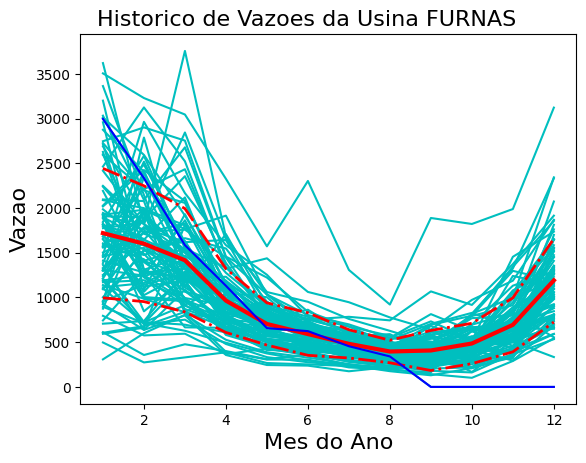

In [9]:
# Gerando um gráfico do histórico de vazões da UHE escolhida
PMOAGO2023.confhd.plot_vaz(Usina)

## Modelo de Otimização

$\hspace{2cm} Min \hspace{0.5cm} \epsilon_{Ago,1931}^2 + \epsilon_{Ago,1932}^2 + ... + \epsilon_{Ago,2022}^2 $



$s.a$

$ Z_{Ago,1931} = \phi_1 \cdot Z_{Jul,1931} + \phi_2 \cdot Z_{Jun,1931} + \phi_3 \cdot Z_{Mai,1931} + \epsilon_{Ago,1931}$

$ Z_{Ago,1932} = \phi_1 \cdot Z_{Jul,1932} + \phi_2 \cdot Z_{Jun,1932} + \phi_3 \cdot Z_{Mai,1932} + \epsilon_{Ago,1932}$

$ \hspace{7cm} \vdots$

$ Z_{Ago,2022} = \phi_1 \cdot Z_{Jul,2022} + \phi_2 \cdot Z_{Jun,2022} + \phi_3 \cdot Z_{Mai,2022} + \epsilon_{Ago,2022}$


Neste código, deseja-se prever as vazões para os meses de:

* Agosto/2023;
* Setembro/2023;
* Outubro/2023;
* Novembro/2023;
* Dezembro/2023.

$ Z_{Ago,2023} = \phi_1 \cdot Z_{Jul,2023} + \phi_2 \cdot Z_{Jun,2023} + \phi_3 \cdot Z_{Mai,2023}$


$ Z_{Set,2023} = \phi_1 \cdot Z_{Ago,2023} + \phi_2 \cdot Z_{Jul,2023} + \phi_3 \cdot Z_{Jun,2023}$

$ Z_{Out,2023} = \phi_1 \cdot Z_{Set,2023} + \phi_2 \cdot Z_{Ago,2023} + \phi_3 \cdot Z_{Jul,2023}$

$ Z_{Nov,2023} = \phi_1 \cdot Z_{Out,2023} + \phi_2 \cdot Z_{Set,2023} + \phi_3 \cdot Z_{Ago,2023}$

$ Z_{Dez,2023} = \phi_1 \cdot Z_{Nov,2023} + \phi_2 \cdot Z_{Out,2023} + \phi_3 \cdot Z_{Set,2023}$

Obs.: Para prever as vazões de cada mês rodou-se o modelo de otimização, portantos os valores de $\phi$ são diferente entre as equações.

In [10]:
from cvxopt import matrix, solvers

dif = (cod[mes] - 8)   # Deferencia entre o mes a ser previsto e o ultimo mes de dados



for _ in range(cod[mes] - 7):

  recorte = Usina['vazoes'][0:91, (cod[mes] - dif - ordem - 1) : (cod[mes] - dif - 1)]
  identidade = np.eye(91)


  # Representação da FOB para problemas quadráticos
  p = matrix(np.zeros(94))
  Q = 2*np.eye(94)
  Q[0][0] = 0
  Q[1][1] = 0
  Q[2][2] = 0
  Q = matrix(Q)


  # Restrições de igualdade
  Aeq = np.concatenate((recorte, identidade), axis = 1)
  Aeq = matrix(Aeq.astype('float'))
  Beq = Usina['vazoes'][0:91, (cod[mes] - dif - 1) : (cod[mes] - dif)]
  Beq = matrix(Beq.astype('float'))



  # Restrições de desigualdade
  A = None
  B = None



  sol = solvers.qp(Q, p, A, B, Aeq, Beq)


  nome = Usina['nome']
  Status = sol['status']
  var_decisao = sol['x']
  fob = sol['primal objective']


  afluencia_prevista = (var_decisao[0] * vazoes[-1][6]) + (var_decisao[1] * vazoes[-1][5]) + (var_decisao[2] * vazoes[-1][4])

  # Incluindo a vazão prevista nos dados de afluência
  Usina['vazoes'][-1][ cod[mes] - dif - 1 ] = afluencia_prevista

  dif -= 1


afl_prevista = Usina['vazoes'][-1]

# Imprimindo os resultados na tela
print('--------------------------------------------------------------------------')
print('----------------------------- RESULTADOS ---------------------------------')
print('--------------------------------------------------------------------------')
print()
print("Dados definidos pelo usuário:")
print(f'UHE: {nome}')
print(f'Mês: {mes}')
print(f'Ordem do Modelo: {ordem}')
print()
print(f'Status do Problema: {Status}')
print()
print(f'Valor da FOB: {fob:.4f}')
print()
print(f'Vazão Prevista para o Mês de {mes}: {afluencia_prevista:.4f} m^3/s')
print()
print('Valor das variáveis de decisão:')
print(f'Phi_1: {var_decisao[0]:.4f}')
print(f'Phi_2: {var_decisao[1]:.4f}')
print(f'Phi_3: {var_decisao[2]:.4f}')
print()
print('Vazões do último ano (Real + Previsões):')
print(f'Afluências Passadas:             {list(afl_passadas)} m^3/s')
print(f'Afluências Passadas + Previstas: {list(afl_prevista)} m^3/s')

#print(var_decisao)





--------------------------------------------------------------------------
----------------------------- RESULTADOS ---------------------------------
--------------------------------------------------------------------------

Dados definidos pelo usuário:
UHE: FURNAS      
Mês: Dez
Ordem do Modelo: 3

Status do Problema: optimal

Valor da FOB: 11303948.3150

Vazão Prevista para o Mês de Dez: 1225.9179 m^3/s

Valor das variáveis de decisão:
Phi_1: 0.1836
Phi_2: 0.8603
Phi_3: 0.9217

Vazões do último ano (Real + Previsões):
Afluências Passadas:             [2997, 2334, 1585, 1131, 657, 624, 455, 341, 0, 0, 0, 0] m^3/s
Afluências Passadas + Previstas: [2997, 2334, 1585, 1131, 657, 624, 455, 524, 480, 544, 882, 1225] m^3/s


# Gráfico

In [14]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, len(afl_passadas) + 1)), y=afl_passadas,
                         mode='lines+markers', name='Afluências Passadas'))

fig.add_trace(go.Scatter(x=list(range(1, len(afl_prevista) + 1)), y=afl_prevista,
                         mode='lines+markers', name='Afluências Passadas + Previstas'))

fig.update_layout(title='Afluências Passadas e Previstas',
                  xaxis_title='Mês',
                  yaxis_title='Vazão Natural Afluente [m^3/s]',
                  legend=dict(x=0.7, y=1),
                  height=500,
                  width=800)


fig.show()